<a href="https://colab.research.google.com/github/neonin04/fastai/blob/main/plant_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 18.0MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 1.2MB 58.8MB/s 
     |████████████████████████████████| 194kB 61.0MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', '92e473cf612240b58434796b193532bb')

In [5]:
search_images_bing

<function fastbook.search_images_bing>

In [6]:
plant_types = 'succulent','cactus','tree'
path = Path('plants')

In [7]:
if not path.exists():
    path.mkdir()
    for o in plant_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [8]:
fns = get_image_files(path)
fns

(#431) [Path('plants/cactus/00000014.jpg'),Path('plants/cactus/00000048.jpg'),Path('plants/cactus/00000122.jpg'),Path('plants/cactus/00000069.jpg'),Path('plants/cactus/00000015.jpg'),Path('plants/cactus/00000081.jpg'),Path('plants/cactus/00000129.jpeg'),Path('plants/cactus/00000018.jpg'),Path('plants/cactus/00000066.jpg'),Path('plants/cactus/00000006.jpg')...]

In [9]:
failed = verify_images(fns)
failed

(#3) [Path('plants/cactus/00000133.jpeg'),Path('plants/succulent/00000082.jpg'),Path('plants/succulent/00000132.jpg')]

In [10]:
failed.map(Path.unlink);

## From Data to DataLoaders

In [13]:
plants = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [14]:
dls = plants.dataloaders(path)

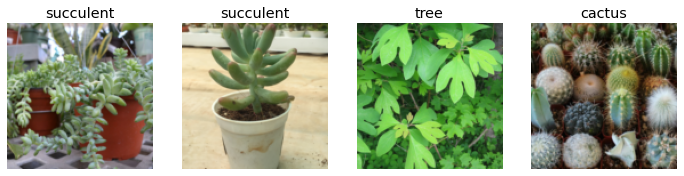

In [15]:
dls.valid.show_batch(max_n=4, nrows=1)

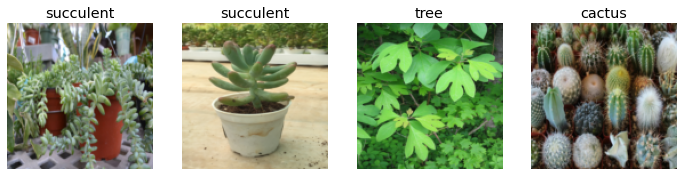

In [16]:
plants = plants.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = plants.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

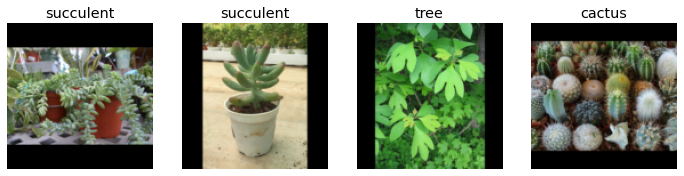

In [17]:
plants = plants.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = plants.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

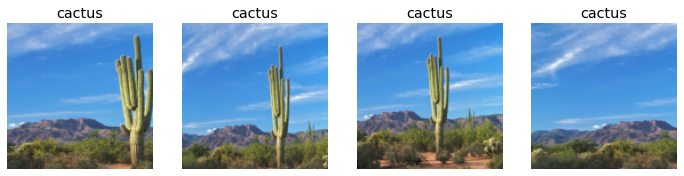

In [18]:
plants = plants.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = plants.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

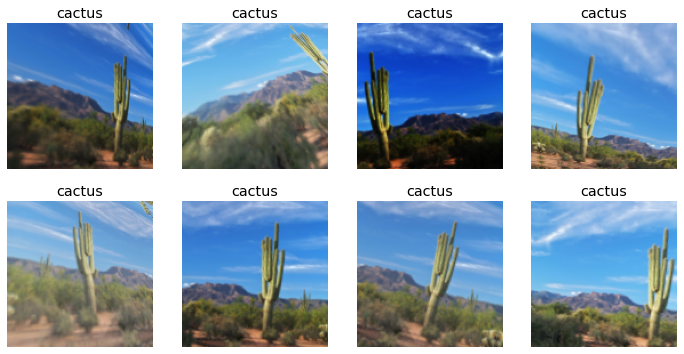

In [19]:
plants = plants.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = plants.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [20]:
plants = plants.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = plants.dataloaders(path)

In [21]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.526929,0.680734,0.235294,00:17


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.698556,0.485082,0.176471,00:16
1,0.610913,0.353697,0.129412,00:17
2,0.496695,0.366276,0.117647,00:17
3,0.413579,0.382893,0.117647,00:17


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


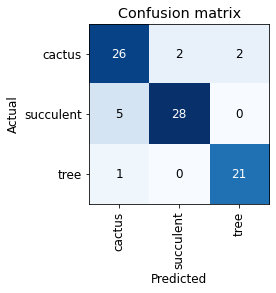

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

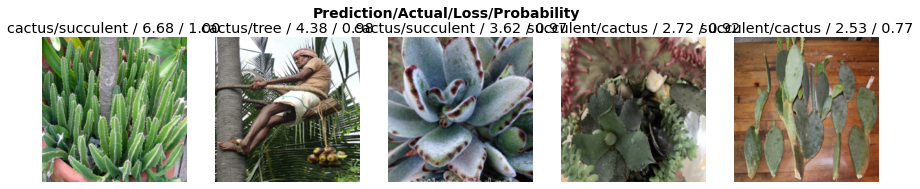

In [24]:
interp.plot_top_losses(5, nrows=1)

In [25]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [27]:
#hide
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [28]:
learn.export()

In [29]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [36]:
learn_inf = load_learner(path/'export.pkl')

In [42]:
learn_inf.predict('plants/cactus/00000014.jpg')

('cactus', tensor(0), tensor([9.9999e-01, 2.6972e-06, 3.6718e-06]))

In [43]:
learn_inf.dls.vocab

['cactus', 'succulent', 'tree']

### Creating a Notebook App from the Model

In [41]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [44]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['plants/cactus/00000014.jpg'])

In [46]:
img = PILImage.create(btn_upload.data[-1])

In [67]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [53]:
pred,pred_idx,probs = learn_inf.predict(img)

In [54]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: cactus; Probability: 1.0000')

In [64]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [57]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [58]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [66]:
#hide_output
VBox([widgets.Label('Select your plant!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

Now that we have everything working in this Jupyter notebook, we can create our application. To do this, start a new notebook and add to it only the code needed to create and show the widgets that you need, and markdown for any text that you want to appear. Have a look at the *bear_classifier* notebook in the book's repo to see the simple notebook application we created.

Next, install Voilà if you haven't already, by copying these lines into a notebook cell and executing it:

    !pip install voila
    !jupyter serverextension enable --sys-prefix voila

Cells that begin with a `!` do not contain Python code, but instead contain code that is passed to your shell (bash, Windows PowerShell, etc.). If you are comfortable using the command line, which we'll discuss more later in this book, you can of course simply type these two lines (without the `!` prefix) directly into your terminal. In this case, the first line installs the `voila` library and application, and the second connects it to your existing Jupyter notebook.

Voilà runs Jupyter notebooks just like the Jupyter notebook server you are using now does, but it also does something very important: it removes all of the cell inputs, and only shows output (including ipywidgets), along with your markdown cells. So what's left is a web application! To view your notebook as a Voilà web application, replace the word "notebooks" in your browser's URL with: "voila/render". You will see the same content as your notebook, but without any of the code cells.

Of course, you don't need to use Voilà or ipywidgets. Your model is just a function you can call (`pred,pred_idx,probs = learn.predict(img)`), so you can use it with any framework, hosted on any platform. And you can take something you've prototyped in ipywidgets and Voilà and later convert it into a regular web application. We're showing you this approach in the book because we think it's a great way for data scientists and other folks that aren't web development experts to create applications from their models.

We have our app, now let's deploy it!

### Deploying your app

As you now know, you need a GPU to train nearly any useful deep learning model. So, do you need a GPU to use that model in production? No! You almost certainly *do not need a GPU to serve your model in production*. There are a few reasons for this:

- As we've seen, GPUs are only useful when they do lots of identical work in parallel. If you're doing (say) image classification, then you'll normally be classifying just one user's image at a time, and there isn't normally enough work to do in a single image to keep a GPU busy for long enough for it to be very efficient. So, a CPU will often be more cost-effective.
- An alternative could be to wait for a few users to submit their images, and then batch them up and process them all at once on a GPU. But then you're asking your users to wait, rather than getting answers straight away! And you need a high-volume site for this to be workable. If you do need this functionality, you can use a tool such as Microsoft's [ONNX Runtime](https://github.com/microsoft/onnxruntime), or [AWS Sagemaker](https://aws.amazon.com/sagemaker/)
- The complexities of dealing with GPU inference are significant. In particular, the GPU's memory will need careful manual management, and you'll need a careful queueing system to ensure you only process one batch at a time.
- There's a lot more market competition in CPU than GPU servers, as a result of which there are much cheaper options available for CPU servers.

Because of the complexity of GPU serving, many systems have sprung up to try to automate this. However, managing and running these systems is also complex, and generally requires compiling your model into a different form that's specialized for that system. It's typically preferable to avoid dealing with this complexity until/unless your app gets popular enough that it makes clear financial sense for you to do so.

For at least the initial prototype of your application, and for any hobby projects that you want to show off, you can easily host them for free. The best place and the best way to do this will vary over time, so check the [book's website](https://book.fast.ai/) for the most up-to-date recommendations. As we're writing this book in early 2020 the simplest (and free!) approach is to use [Binder](https://mybinder.org/). To publish your web app on Binder, you follow these steps:

1. Add your notebook to a [GitHub repository](http://github.com/).
2. Paste the URL of that repo into Binder's URL, as shown in <<deploy-binder>>.
3. Change the File dropdown to instead select URL.
4. In the "URL to open" field, enter `/voila/render/name.ipynb` (replacing `name` with the name of for your notebook).
5. Click the clickboard button at the bottom right to copyt the URL and paste it somewhere safe. 
6. Click Launch.

<img alt="Deploying to Binder" width="800" caption="Deploying to Binder" id="deploy-binder" src="https://github.com/fastai/fastbook/blob/master/images/att_00001.png?raw=1">

The first time you do this, Binder will take around 5 minutes to build your site. Behind the scenes, it is finding a virtual machine that can run your app, allocating storage, collecting the files needed for Jupyter, for your notebook, and for presenting your notebook as a web application.

Finally, once it has started the app running, it will navigate your browser to your new web app. You can share the URL you copied to allow others to access your app as well.

For other (both free and paid) options for deploying your web app, be sure to take a look at the [book's website](https://book.fast.ai/).

You may well want to deploy your application onto mobile devices, or edge devices such as a Raspberry Pi. There are a lot of libraries and frameworks that allow you to integrate a model directly into a mobile application. However, these approaches tend to require a lot of extra steps and boilerplate, and do not always support all the PyTorch and fastai layers that your model might use. In addition, the work you do will depend on what kind of mobile devices you are targeting for deployment—you might need to do some work to run on iOS devices, different work to run on newer Android devices, different work for older Android devices, etc. Instead, we recommend wherever possible that you deploy the model itself to a server, and have your mobile or edge application connect to it as a web service.

There are quite a few upsides to this approach. The initial installation is easier, because you only have to deploy a small GUI application, which connects to the server to do all the heavy lifting. More importantly perhaps, upgrades of that core logic can happen on your server, rather than needing to be distributed to all of your users. Your server will have a lot more memory and processing capacity than most edge devices, and it is far easier to scale those resources if your model becomes more demanding. The hardware that you will have on a server is also going to be more standard and more easily supported by fastai and PyTorch, so you don't have to compile your model into a different form.

There are downsides too, of course. Your application will require a network connection, and there will be some latency each time the model is called. (It takes a while for a neural network model to run anyway, so this additional network latency may not make a big difference to your users in practice. In fact, since you can use better hardware on the server, the overall latency may even be less than if it were running locally!) Also, if your application uses sensitive data then your users may be concerned about an approach which sends that data to a remote server, so sometimes privacy considerations will mean that you need to run the model on the edge device (it may be possible to avoid this by having an *on-premise* server, such as inside a company's firewall). Managing the complexity and scaling the server can create additional overhead too, whereas if your model runs on the edge devices then each user is bringing their own compute resources, which leads to easier scaling with an increasing number of users (also known as *horizontal scaling*).

> A: I've had a chance to see up close how the mobile ML landscape is changing in my work. We offer an iPhone app that depends on computer vision, and for years we ran our own computer vision models in the cloud. This was the only way to do it then since those models needed significant memory and compute resources and took minutes to process inputs. This approach required building not only the models (fun!) but also the infrastructure to ensure a certain number of "compute worker machines" were absolutely always running (scary), that more machines would automatically come online if traffic increased, that there was stable storage for large inputs and outputs, that the iOS app could know and tell the user how their job was doing, etc. Nowadays Apple provides APIs for converting models to run efficiently on device and most iOS devices have dedicated ML hardware, so that's the strategy we use for our newer models. It's still not easy but in our case it's worth it, for a faster user experience and to worry less about servers. What works for you will depend, realistically, on the user experience you're trying to create and what you personally find is easy to do. If you really know how to run servers, do it. If you really know how to build native mobile apps, do that. There are many roads up the hill.

Overall, we'd recommend using a simple CPU-based server approach where possible, for as long as you can get away with it. If you're lucky enough to have a very successful application, then you'll be able to justify the investment in more complex deployment approaches at that time.

Congratulations, you have successfully built a deep learning model and deployed it! Now is a good time to take a pause and think about what could go wrong.